# Introduction

We're dealing with two datasets of red and white wines and their chemical and pyscial properties, each labeled with a quality score. The goal here is to develop a classificator to output the estimated quality score for previously unseen records.

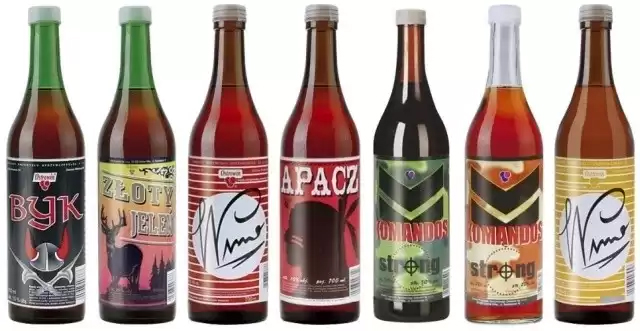

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/datacourage_wine /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/datacourage_wine': File exists
/content/gdrive/My Drive/Colab Notebooks/datacourage_wine


## Libraries & functions
Let's now import the necessary libraries and function we're gonna use in this notebook.

### General
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `timeit` - cell runtime check
- `re` - regular expression handling

In [3]:
import numpy as np
import pandas as pd
import timeit
import re

### Visualization
- `plotly.graph_objects` - Plotly graph object handling (with better control than `plotly.express`)
- `matplotlib.pyplot` - matplotlib plotting interface
- `plot_confusion_matrix` - confusion matrix plotting for evaluating classification accuracy

In [56]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

### Scikit-learn models
Various classification models of different types found in the sklearn framework.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Scikit-learn extra
Some extra scikit-learn functions for:

- model selection
- pipeline creation
- model evaluation

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

# Load data
Let's load data using `pd.read_csv` function. The file is not precisely comma-separated, so we need to change the separator object to semicolon using `sep` parameter and check the shape of the dataset.

## Red wine

In [4]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df_red.shape

(1599, 12)

## White wine

In [6]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
df_white.shape

(4898, 12)

## Merge datasets
Even though the number of records in the white wine dataset is 3x larger than red wines, the number of features in each dataset is equal, so we're free to combine the red and white wine datasets to have more observations and hopefully, a better generalizing estimator later on. Let's merge them using `pd.concat()` function.

Before doing so, let's add a `color` feature representing red or white color.

In [8]:
# add color feature
df_red['color'] = 'red'
df_white['color'] = 'white'

# concatenate datasets and reset indexing
df = pd.concat([df_red, df_white], ignore_index=True) 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Rename columns
For a better readibility let's rename the columns and replace spaces with an underscore using regex `re.sub()` function.

In [9]:
# replace whitespaces
old_column_names = df.columns.values.tolist()
new_column_names = [re.sub('\s', '_', col_name) for col_name in old_column_names]

# rename column names
df.columns = new_column_names
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Shuffle
To avoid any order-related correlations let's randomize our dataset using `pd.sample()` function with `frac=1` attribute.

In [10]:
# shuffle and reset indexing
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,6.3,0.18,0.24,3.4,0.053,20.0,119.0,0.99373,3.11,0.52,9.2,6,white
1,6.8,0.14,0.18,1.4,0.047,30.0,90.0,0.99164,3.27,0.54,11.2,6,white
2,7.3,0.22,0.50,13.7,0.049,56.0,189.0,0.99940,3.24,0.66,9.0,6,white
3,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,5,white
4,7.3,0.21,0.29,1.6,0.034,29.0,118.0,0.99170,3.30,0.50,11.0,8,white


## Convert categorical values
In order for the algorithms to work properly we need to convert any categorical values in our datasets to dummy encoded columns. In our situation only `color` feature is not numerical. This could have as well been done at the very beginning but whatever ;)

In [11]:
df = pd.get_dummies(df, columns=['color'])
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,6.3,0.18,0.24,3.4,0.053,20.0,119.0,0.99373,3.11,0.52,9.2,6,0,1
1,6.8,0.14,0.18,1.4,0.047,30.0,90.0,0.99164,3.27,0.54,11.2,6,0,1
2,7.3,0.22,0.50,13.7,0.049,56.0,189.0,0.99940,3.24,0.66,9.0,6,0,1
3,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,5,0,1
4,7.3,0.21,0.29,1.6,0.034,29.0,118.0,0.99170,3.30,0.50,11.0,8,0,1


# Data exploration
Once we have our data loaded and tidied-up let's do some exploratory data analysis.

## Values info
Let's print an overview of the type information in the DataFrame and find potential issues.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color_red             6497 non-null   uint8  
 13  color_white           6497 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 621.9 KB


The data seems to be really clean. There are no missing values in the dataset and the dtypes are very consistent, so we're good to go.

## Statistical info
Let's generate a DataFrame of statistical measures for each column to find potential issues. 

In [13]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


At the first glance it looks like there might be some possible outliers in various columns as some `min` and `max` values are quite distant from `mean` considering standard deviation values `std` (e.g. `residual_sugar` or `free_sulfur_dioxide`). Let's investigate further.

## Box plot
I'll use box plot to visual potential outliers in the dataset. You can change the feature to visualize using a dropdown menu.

To do so let's create:

1. A list of features to investigate (excluding wine colors and quality labels)
2. An initial data box plot using Plotly's `go.Box()` function.
3. A dropdown menu to update the graph to show other feature's box plot.
4. A layout object to specify figure's properties.
5. A figure object using `go.Figure()` to put everything together.

In [14]:
feature_list = [
                'fixed_acidity',
                'volatile_acidity',
                'citric_acid',
                'residual_sugar',
                'chlorides',
                'free_sulfur_dioxide',
                'total_sulfur_dioxide',
                'density',
                'pH',
                'sulphates',
                'alcohol' 
]

###############
# INITIAL DATA
###############

initial_data = [
        go.Box(
            y = df['fixed_acidity'],
            name = 'fixed_acidity',
            boxpoints='suspectedoutliers', # display outliers
            marker = dict(color='orange') # box color
            )
]

###############
# DROPDOWN MENU
###############

updatemenus = [
               dict(
                    buttons=list(
                        [
                         dict(
                             label=feat, # dropdown menu item name
                             method='update', #  modify data and layout attributes
                             args=[
                                   {'y': [df[feat]]}, # update y-axis data
                                   {'name': feat}, # update name
                                   {'name': feat} # update y-axis title
                                   ]
                              ) for feat in feature_list # for each feature
                         ]),
                    direction='down',
                    showactive=True,
                    x=0.5, # x positioning
                    xanchor='center',
                    y=1.07, # y positioning
                    yanchor='top'
                   )
              ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Box plot for:', x=0.5),
                   width=800,
                   height=800,
                   updatemenus=updatemenus               
                  )

fig = go.Figure(
    data=initial_data,
    layout=layout
)

fig.show()

As we can see there are definitely some outliers (e.g. `chlorides`, `residual_sugar` or `free_sulfur_dioxide`) in the dataset which can both negatively influence the performane of the model. I'll address the issue later on.

## Correlation heatmap
Let's investigate the correlation between the features. The further away the value is from 0, the more positively or negatively correlated the features are. I'll use Plotly's `go.Heatmap()` function to visualize it.

In [15]:
###############
# DATA
###############

data = go.Heatmap(
                    z=df.corr(), # compute correlation matrix
                    x=df.columns,
                    y=df.columns,
                    colorscale='RdBu',
                    reversescale=True # flip colorscale to reflect red(+), blue(-)
                   )                      

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Feature correlation heatmap', x=0.5),
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
                data=data,
                layout=layout
               )
fig.show()

We can see that the correlations between wine features in our dataset exist, however they are not too strong. The only strong relationships we can see are:

- positive correlation (0.72) between free and total sulfur dioxide,
- positive correlation (-0.67) between alcohol and density

Obviously there are stronger correlation between the wine colors and their features but this should not be something to worry about.

## Label correlation
From the heatmap we can see that the correlation coefficient between the quality of the wine and alcohol content is the most positively correlated with each other, whereas density most negatively correlated. Let's see how other features influence the quality using visualizing a simple bar plot using `go.Bar()`. 

In [16]:
# compute pairwise correlation of DataFrame columns, filter quality only and sort
correlations = df.corr()['quality'].sort_values(ascending=False)

###############
# DATA
###############

data = [
        go.Bar(
            x=correlations.index,
            y=correlations.values,
            marker_color='orange',
    )
        ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Quality correlation', x=0.5),
                   xaxis=go.layout.XAxis(title='Feature name'),
                   yaxis=go.layout.YAxis(title='Correlation value'),
                   bargap=0.2,
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=data,
    layout=layout
    )

fig.show()

As we can see alcohol has the largest positive correlation with quality, whereas density and volatile acidity influence the quality negatively the most.

## Feature distribution
Let's investigate the distribution of the feature observations whether we're dealing with quite normally distributed or skewed data. You can change the feature to show with a dropdown menu.

In [17]:
###############
# DATA
###############

initial_data = [
        go.Histogram(
            x = df['fixed_acidity'],
            marker_color='orange',
            )
]

###############
# DROPDOWN MENU
###############

updatemenus = [
               dict(
                    buttons=list(
                        [
                         dict(
                             label=feat, # dropdown menu item name
                             method='update', #  modify data and layout attributes
                             args=[
                                   {'x': [df[feat]]}, # update y-axis data
                                   {'name': feat} # update y-axis title
                                   ]
                              ) for feat in feature_list # for each feature
                                ]),
                    direction='down',
                    showactive=True,
                    x=0.5, # x positioning
                    xanchor='center',
                    y=1.07, # y positioning
                    yanchor='top'
                   )
              ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Box plot for:', x=0.5),
                   xaxis=go.layout.XAxis(title='Feature value'),
                   yaxis=go.layout.YAxis(title='Number of observations'),
                   width=800,
                   height=800,
                   updatemenus=updatemenus               
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=initial_data,
    layout=layout
)

fig.show()

We can see that some of the features are quite significantly skewed (mostly right) from a normal distribution which due to data assymetry can lead to a model bias.

## Class balance
Another thing to check is the representation of each of the labels. Let's see if there're issues with the balance of the number of observations for each class which can cause issues with minority class detection of our classifier.

In [18]:
###############
# DATA
###############

data = [
        go.Histogram(
            x=df['quality'],
            xbins=dict(
                size=0.5
            ),
            marker_color='orange',
    )            
        ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text="Class distribution", x=0.5),
                   xaxis=go.layout.XAxis(title='Class name'),
                   yaxis=go.layout.YAxis(title='Number of observations'),
                   bargap=0.2,
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=data,
    layout=layout
    )

fig.show()

There's a vast overrepresentation of 5, 6 and 7-rated wines (a total of a couple of thousand observations) whereas wines rated the lowest and the highest make only around 400 cases. There's a clear class imbalance, which will have to be addressed later on, even though it might be extremely difficult for the two least-represented classes - 3 and 9.

# Data preprocessing
Let's preprocess our dataset to get it ready for model building.

## Outliers
Outliers, meaning the observations which are significatly different from the rest of the data, can badly influence the performance of our classifier. 

To get rid of them I'll use Z-score which calculates the distance of the observation from the mean using a multiplication of standard devation. Most of the outliers are positioned more than three standard deviations away from the mean. The formula is:


$ Z_{score} = \frac{value - mean}{std}$

### Find outliers
To find outliers I'll go through each column of the DataFrame, calculate an absolute value of a z-score for all values and return a boolean filter Series (with index values inherited from the original Series) indicating `True` if the observation is an outlier (|z-score| < 3) and `False` otherwise.

I'll skip `quality` column to avoid getting rid of small classes.

In [20]:
# create a copy of the DataFrame
df_filter = df.copy()

for f in df.columns:  
  
  # skip label column
  if f == 'quality':
    df_filter[f] = False
  else:
    # calculate absolute z-score
    z_score = np.abs(stats.zscore(df[f]))
    # replace values with boolean values depending on a condition
    outliers = np.where(z_score>3, True, False)
    # return a new series with a correct indexing
    df_filter[f] = pd.Series(outliers, index=df[f].index)

df_filter.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Drop outlier rows
Once we have a boolean DataFrame, we can use it to remove outliers from the original DataFrame. I'll use the tilde `~` operator in order to create a complementary DataFrame (flip True and False values). 

The filtering will result in `Nan` values instead of outliers. I'll get rid of the rows which contain any and reset the DataFrame index.

In [21]:
# filter DataFrame
df = df[~df_filter]

# drop NaN values
df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,6.3,0.18,0.24,3.4,0.053,20.0,119.0,0.99373,3.11,0.52,9.2,6.0,0.0,1.0
1,6.8,0.14,0.18,1.4,0.047,30.0,90.0,0.99164,3.27,0.54,11.2,6.0,0.0,1.0
2,7.3,0.22,0.50,13.7,0.049,56.0,189.0,0.99940,3.24,0.66,9.0,6.0,0.0,1.0
3,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,5.0,0.0,1.0
4,7.3,0.21,0.29,1.6,0.034,29.0,118.0,0.99170,3.30,0.50,11.0,8.0,0.0,1.0


### Check shape
After filtering out outliers it's good to check if our dataset didn't shrink too much.

In [22]:
df.shape

(6492, 14)

We've lost around 7% of out data due to outlier removal. 

## Features/labels split
Let's divide our dataset into features and labels.

In [23]:
X = df.drop('quality', axis=1)
y = df['quality']

## Standarization
Remembering the statistical exploration of our dataset we can say it don't contain standard normally distributed data, so we should standardize the features by removing the mean and scaling to unit variance.

In [24]:
X = StandardScaler().fit(X).transform(X)

## Dataset split
Let's split the dataset into train and test sets to avoid any data leakage.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train.shape

(4869, 13)

In [28]:
X_test.shape

(1623, 13)

# Modelling
Let's pick some most popular classifiers available within sklearn framework and test them.

In [29]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

## Classification reports

In [30]:
for name, clf in classifiers.items():
  print(f'\n\nChecking {name} classifier:\n')
  
  clf.fit(X_train, y_train)

  preds = clf.predict(X_test)

  print(classification_report(y_test, preds, zero_division=0))



Checking Logistic Regression classifier:

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.75      0.06      0.11        53
         5.0       0.59      0.58      0.59       547
         6.0       0.51      0.71      0.60       712
         7.0       0.44      0.19      0.26       261
         8.0       0.00      0.00      0.00        47

    accuracy                           0.54      1623
   macro avg       0.38      0.25      0.26      1623
weighted avg       0.52      0.54      0.50      1623



Checking K-Nearest Neighbors classifier:

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.21      0.08      0.11        53
         5.0       0.60      0.63      0.61       547
         6.0       0.57      0.62      0.59       712
         7.0       0.52      0.47      0.49       261
         8.0       0.28      0.11      0.15 

It looks like Random Forest and Decision Tree classifiers did the best in this premature test, so let's evaluate them further.

## Resampling
We can see that the models are struggling with the minority classes due to the class imbalance. Let's try to solve this issue using.

In [31]:
# # decision tree evaluated on imbalanced dataset with SMOTE oversampling
# from numpy import mean
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.tree import DecisionTreeClassifier
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler

# # define pipeline
# steps = [
#          ('over', SMOTE(k_neighbors=2)),
#          ('under', RandomUnderSampler()),
#          ('model', RandomForestClassifier())
#          ]
# pipeline = Pipeline(steps=steps)



# # # print(classification_report(y_test, preds, zero_division=0))
# # # evaluate pipeline
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# # print('Mean ROC AUC: %.3f' % mean(scores))

In [32]:
# pipeline.fit(X_train, y_train)
# preds = pipeline.predict(X_test)
# print(classification_report(y_test, preds, zero_division=0))

In [33]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.pipeline import Pipeline

# # define pipeline
# over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# # transform the dataset
# X, y = pipeline.fit_resample(X, y)

In [34]:
# # Import SMOTE module
# from imblearn.over_sampling import SMOTE
# # Create model and fit the training set to create a new training set
# sm = SMOTE(k_neighbors=3, random_state = 2) 
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
# # Create random forest model
# # forest = RandomForestClassifier(n_estimators=100,random_state = 0)
# # Fit the model to the new train set
# clf.fit(X_train_res, y_train_res.ravel())
# # # Test out-of-sample test set
# y_pred = clf.predict(X_test)
# # Classification report
# print(classification_report(y_test, y_pred.round(), digits=3))
# # Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
# accuracy = cross_val_score(forest, X, y,scoring = 'roc_auc_ovr',cv=10)
# print('cross validation score with roc_auc_ovr scoring',accuracy.mean())
# # Calculate roc_auc score with multiclass parameter
# print('roc_auc_score',roc_auc_score(y_test,forest.predict_proba(X_test), multi_class='ovr'))

# Evaluation

In [35]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.71      0.19      0.30        53
         5.0       0.73      0.70      0.72       547
         6.0       0.64      0.78      0.71       712
         7.0       0.68      0.51      0.59       261
         8.0       0.84      0.34      0.48        47

    accuracy                           0.68      1623
   macro avg       0.60      0.42      0.46      1623
weighted avg       0.69      0.68      0.67      1623



In [36]:
from sklearn.model_selection import GridSearchCV

def model_evaluation(estimator, parameters):
  pipe = make_pipeline(
      StandardScaler(),
      estimator
      )

  search = GridSearchCV(
      pipe,
      parameters,
      scoring='accuracy',
      cv=5,
      verbose=1,
      n_jobs=-1
      )
  start = timeit.default_timer()
  search.fit(X_train, y_train)
  stop = timeit.default_timer()

  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_cv = cross_val_score(search, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=score_test,
                            score_train=score_train,
                            score_cv=score_cv
                           )

  return evaluation_results

In [37]:
parameters = {
    'randomforestclassifier__n_estimators': [100, 200, 500],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__class_weight': ['balanced', None],
             }
rfc_evaluation_results = model_evaluation(RandomForestClassifier(), parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 19.5min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 15.9min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 16.0min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 16.0min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 15.9min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 15.9min finished


In [50]:
clf = rfc_evaluation_results['b_estimator']
clf

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        v

In [39]:
# Pipeline(memory=None,
#          steps=[('standardscaler',
#                  StandardScaler(copy=True, with_mean=True, with_std=True)),
#                 ('randomforestclassifier',
#                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
#                                         class_weight='balanced',
#                                         criterion='entropy', max_depth=None,
#                                         max_features='auto',
#                                         max_leaf_nodes=None, max_samples=None,
#                                         min_impurity_decrease=0.0,
#                                         min_impurity_split=None,
#                                         min_samples_leaf=1, min_samples_split=2,
#                                         min_weight_fraction_leaf=0.0,
#                                         n_estimators=200, n_jobs=None,
#                                         oob_score=False, random_state=None,
#                                         verbose=0, warm_start=False))],
#          verbose=False)

In [51]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.79      0.21      0.33        53
         5.0       0.73      0.69      0.71       547
         6.0       0.63      0.79      0.70       712
         7.0       0.70      0.50      0.58       261
         8.0       0.84      0.34      0.48        47

    accuracy                           0.68      1623
   macro avg       0.62      0.42      0.47      1623
weighted avg       0.69      0.68      0.67      1623



## Cross validation

In [52]:
def confusion_matrix_plot(classifier):
  fig, (ax1, ax2) = plt.subplots(nrows=1,
                           ncols=2,
                           sharex=True,
                           sharey=True,
                           figsize=(20,10))
  plot_confusion_matrix(classifier, X_train, y_train, ax=ax1)
  plot_confusion_matrix(classifier, X_test, y_test, ax=ax2)

  plt.xticks(rotation=90) 
  ax1.set(title='Train set')
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.set(title='Test set') 
  ax2.tick_params(axis='x', labelrotation=90)

  return plt.show()

In [53]:
accuracy = cross_val_score(clf, X, y, scoring='roc_auc_ovr', cv=10)
print('cross validation score with roc_auc_ovr scoring',accuracy.mean())

cross validation score with roc_auc_ovr scoring 0.8598708702140616


## ROC auc

In [54]:
# Calculate roc_auc score with multiclass parameter
print('roc_auc_score',roc_auc_score(y_test,clf.predict_proba(X_test), multi_class='ovr'))

roc_auc_score 0.8453298982351328


### Confusion matrix

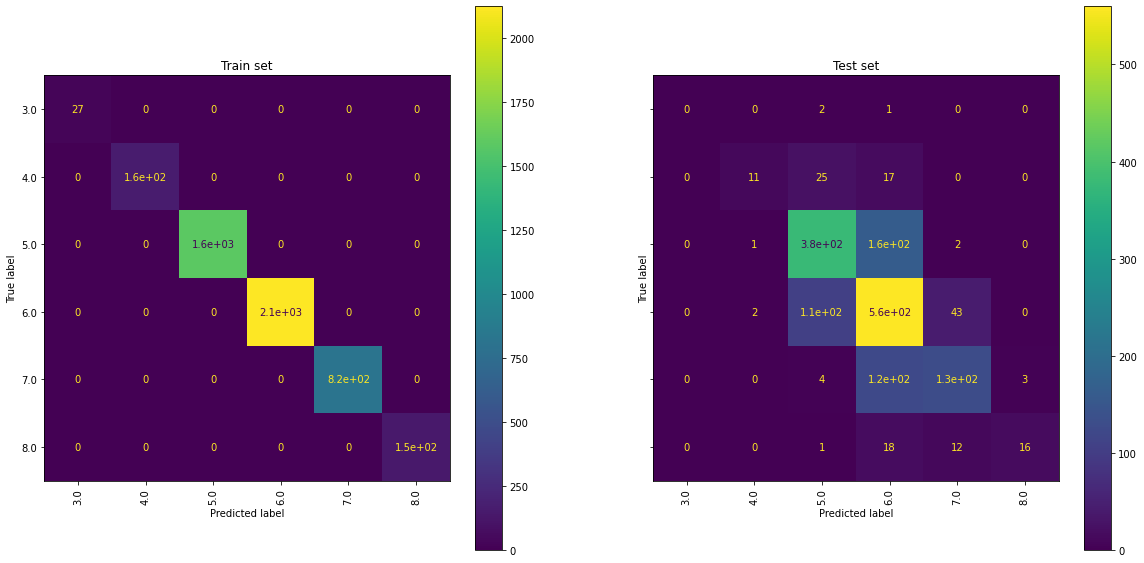

In [57]:
confusion_matrix_plot(clf)

### Learning curve

In [64]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")


    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

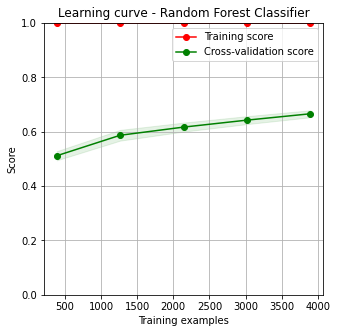

In [65]:
plot_learning_curve(
                    clf,
                    title='Learning curve - Random Forest Classifier',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

## Oversampling

In [43]:
# Import SMOTE module
from imblearn.over_sampling import SMOTE

# Create model and fit the training set to create a new training set
sm = SMOTE(random_state = 0) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Create random forest model
clf = RandomForestClassifier(n_estimators=100, random_state = 0)

# Fit the model to the new train set
clf.fit(X_train_res, y_train_res.ravel())

# # Test out-of-sample test set
y_pred = clf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred.round(), digits=3))

# Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
accuracy = cross_val_score(clf, X, y,scoring = 'roc_auc_ovr',cv=10)
print('cross validation score with roc_auc_ovr scoring',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score',roc_auc_score(y_test,clf.predict_proba(X_test), multi_class='ovr'))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing i

              precision    recall  f1-score   support

         3.0      0.000     0.000     0.000         3
         4.0      0.292     0.396     0.336        53
         5.0      0.718     0.695     0.706       547
         6.0      0.689     0.647     0.668       712
         7.0      0.556     0.594     0.574       261
         8.0      0.311     0.404     0.352        47

    accuracy                          0.638      1623
   macro avg      0.428     0.456     0.439      1623
weighted avg      0.652     0.638     0.644      1623

cross validation score with roc_auc_ovr scoring 0.864828702180616
roc_auc_score 0.8010067591126804


## ROC Curve

In [44]:
# # Calculate cv score with 'roc_auc_ovr' scoring and 10 folds
# accuracy = cross_val_score(clf, X, y,scoring = 'roc_auc_ovr',cv=10)
# print('cross validation score with roc_auc_ovr scoring',accuracy.mean())
# # Calculate roc_auc score with multiclass parameter
# print('roc_auc_score',roc_auc_score(y_test,forest.predict_proba(X_test), multi_class='ovr'))

In [45]:
sdfgsdfg

NameError: ignored

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Train and fit the Decision Tree Classification model
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
# Evaluate the model with out-of-sample test set
y_pred = tree.predict(X_test)
# Classification report
print(classification_report(y_test, y_pred.round(), digits=3))
# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score(tree, X, y,scoring = 'roc_auc_ovr',cv=5)
print('cross validation score with roc_auc_ovr scoring',accuracy.mean())
# Calculate roc_auc score with multiclass parameter
print('roc_auc_score',roc_auc_score(y_test,tree.predict_proba(X_test), multi_class='ovr'))

In [ ]:
dghfdhdf

In [ ]:
# shape of the original dataset
org_shape = df.shape

# calculate z-score
z_score = np.abs(stats.zscore(df))
df = df[(z_score<3).all(axis=1)]

# shape of the filtered dataset
new_shape = df.shape

print(f'Shape of the original dataset: {org_shape}\nShape of the filtered dataset: {new_shape}')

We lost around 500 observations which makes less than 10% of the whole dataset. This amount is not significant, so we can carry on.

https://towardsdatascience.com/comparing-classification-models-for-wine-quality-prediction-6c5f26669a4f
https://www.kaggle.com/mgmarques/wines-type-and-quality-classification-exercises
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/